In [1]:
!pip install xgboost --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [3]:
raw_data = pd.read_csv("Dataset/power.csv")
raw_data

,Timestamp,Power(kW)
0,2019-01-01 00:00:00,705.876648
1,2019-01-01 00:10:00,884.711670
2,2019-01-01 00:20:00,982.875000
3,2019-01-01 00:30:00,1115.943359
4,2019-01-01 00:40:00,1263.841675
...,...,...
136725,2021-08-14 23:10:00,2757.728271
136726,2021-08-14 23:20:00,2758.323242
136727,2021-08-14 23:30:00,2759.243408
136728,2021-08-14 23:40:00,2761.261719


In [4]:
df = raw_data.set_index("Timestamp")
df. index = pd.to_datetime(df.index)

In [5]:
df.head()

,Power(kW)
Timestamp,
2019-01-01 00:00:00,705.876648
2019-01-01 00:10:00,884.711670
2019-01-01 00:20:00,982.875000
2019-01-01 00:30:00,1115.943359
2019-01-01 00:40:00,1263.841675


In [6]:
df.describe()

,Power(kW)
count,136730.000000
mean,1138.556350
std,1078.419992
min,-48.596668
25%,80.394167
50%,778.220825
75%,2310.443237
max,2779.423340


In [7]:
df = df.loc[df['Power(kW)']>0]

In [8]:
print(np.isnan(df).any())
print(np.isinf(df).any())


Power(kW)    False
dtype: bool
Power(kW)    False
dtype: bool


In [9]:
df.shape

(112155, 1)

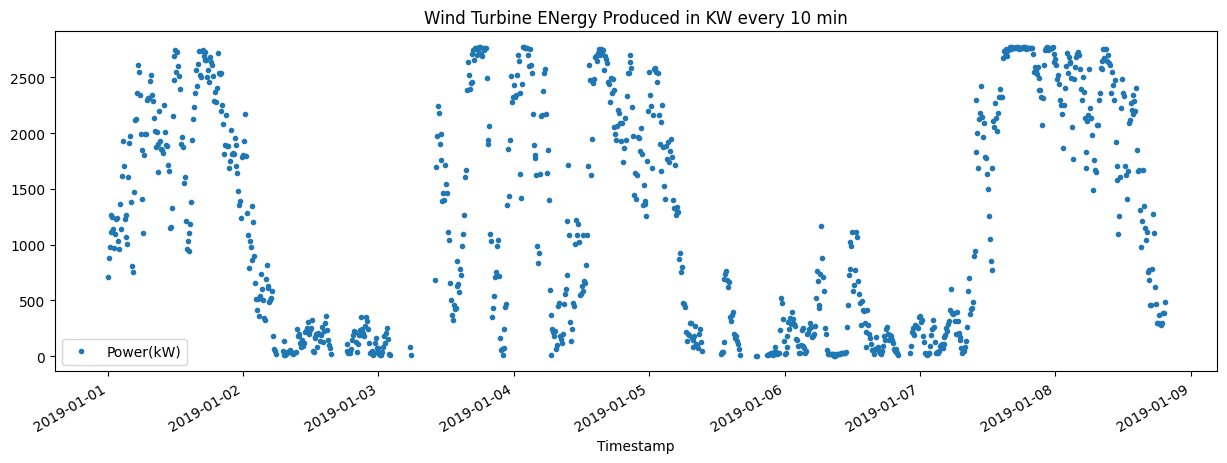

In [10]:

df[:1000].plot(style='.', figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW every 10 min')
plt.show()

In [11]:
df_day_avg = df.resample('H').mean()
df_day_avg.shape

(22968, 1)

In [12]:
df_day_avg = df_day_avg[df_day_avg['Power(kW)'].notnull()]

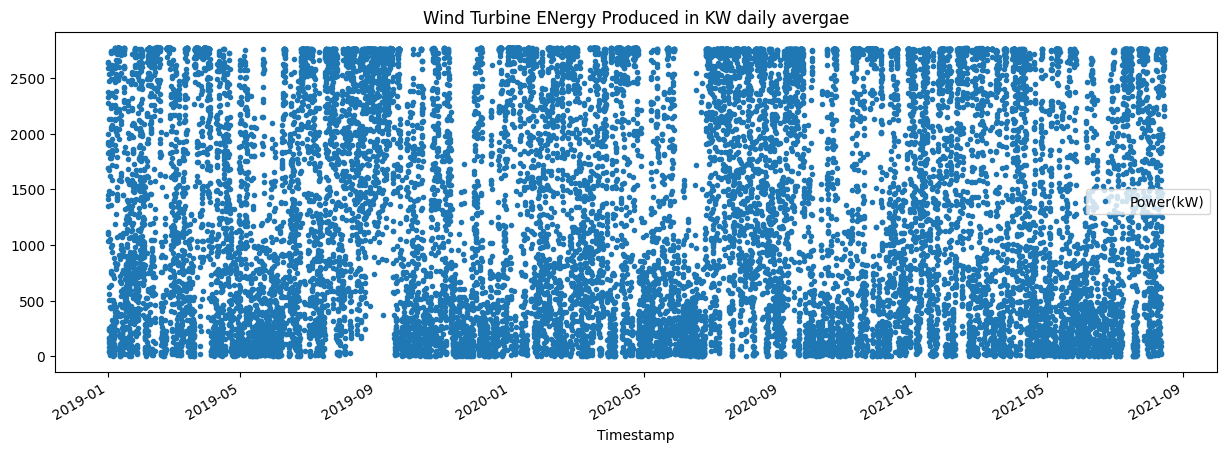

In [13]:
df_day_avg.plot(style='.', figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW daily avergae')
plt.show()

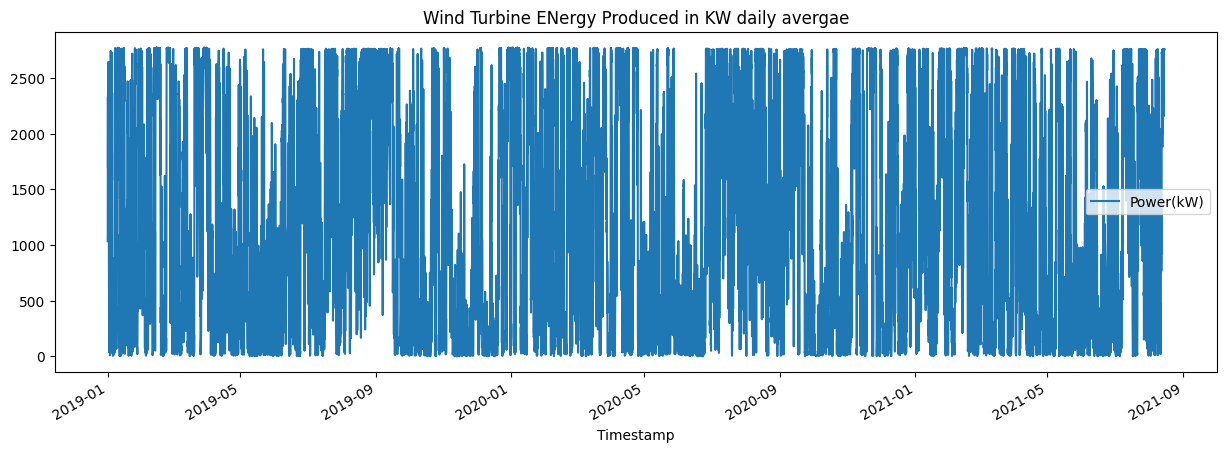

In [14]:
df_day_avg.plot(figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW daily avergae')
plt.show()

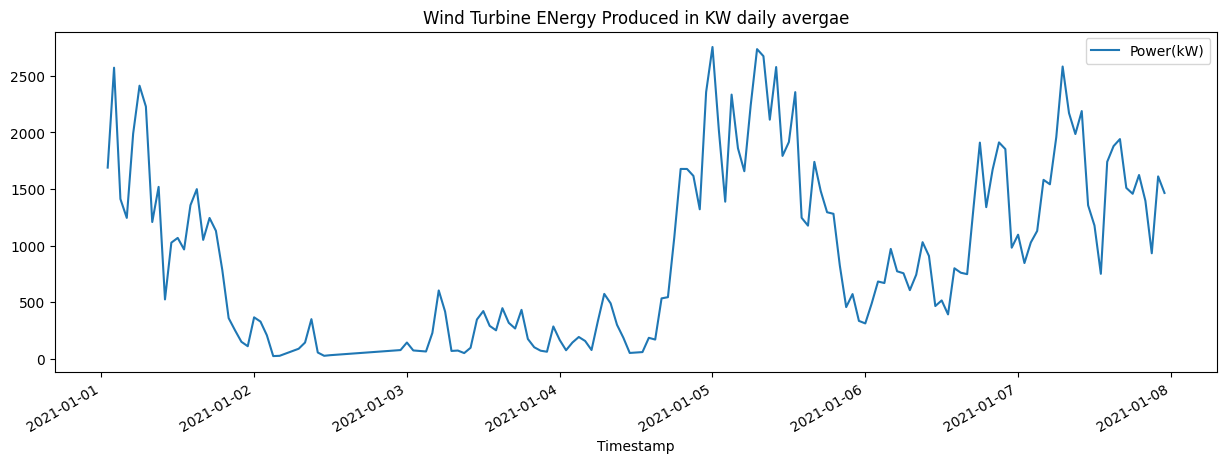

In [15]:
df_day_avg.loc[(df_day_avg.index> '01-01-2021') & (df_day_avg.index < '01-08-2021')].plot(figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW daily avergae')
plt.show()

In [50]:
def feature_creation(df): 
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.to_series().dt.day // 7 + 1
    return df

<Axes: xlabel='week', ylabel='Power(kW)'>

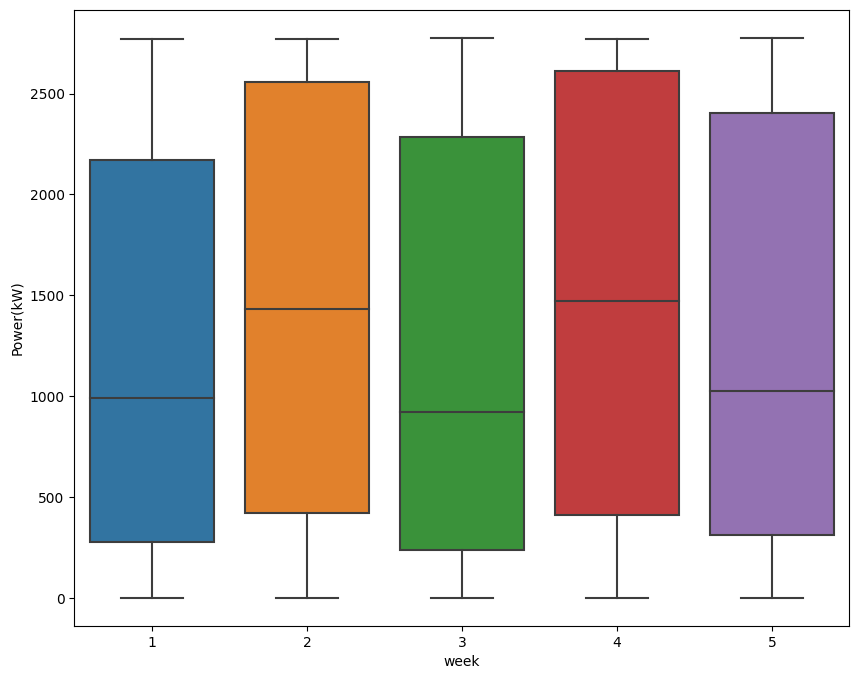

In [51]:
df_day_avg = feature_creation(df_day_avg)

fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df_day_avg, x = 'week', y = 'Power(kW)')

<Axes: xlabel='dayofweek', ylabel='Power(kW)'>

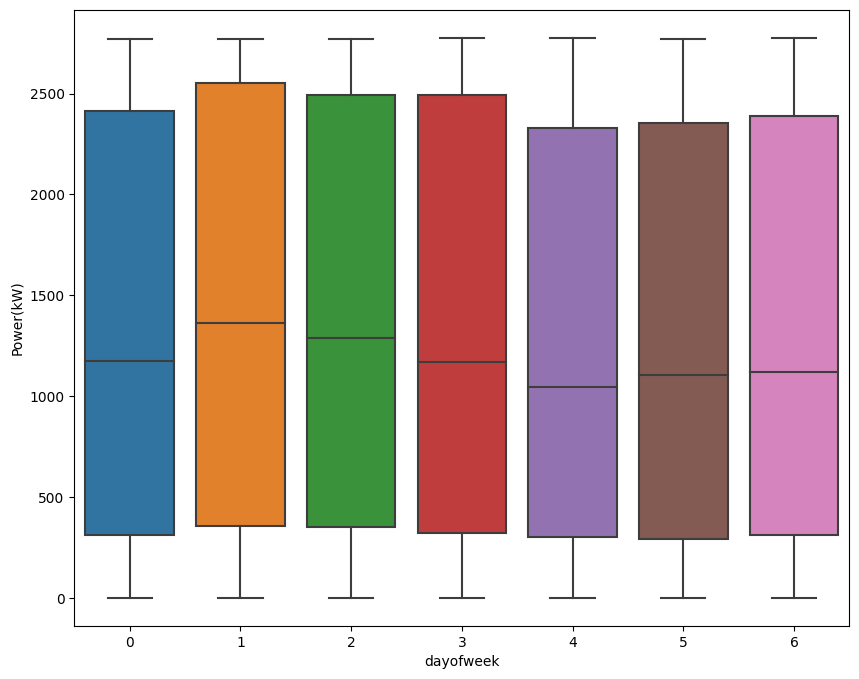

In [52]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df_day_avg, x = 'dayofweek', y = 'Power(kW)')

<Axes: xlabel='month', ylabel='Power(kW)'>

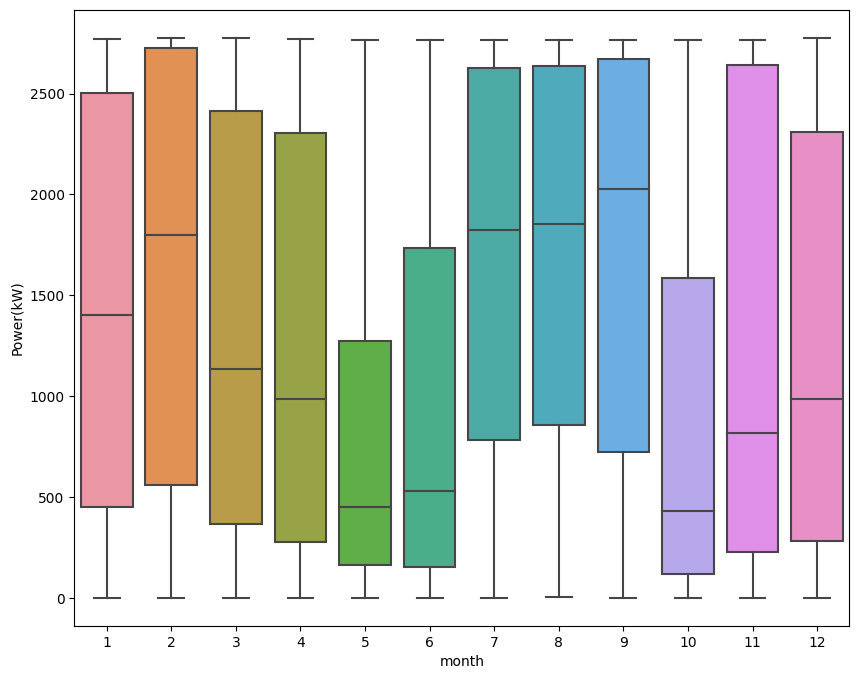

In [53]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df_day_avg, x = 'month', y = 'Power(kW)')

## CREATE our Model

### TRAIN/TEST Split

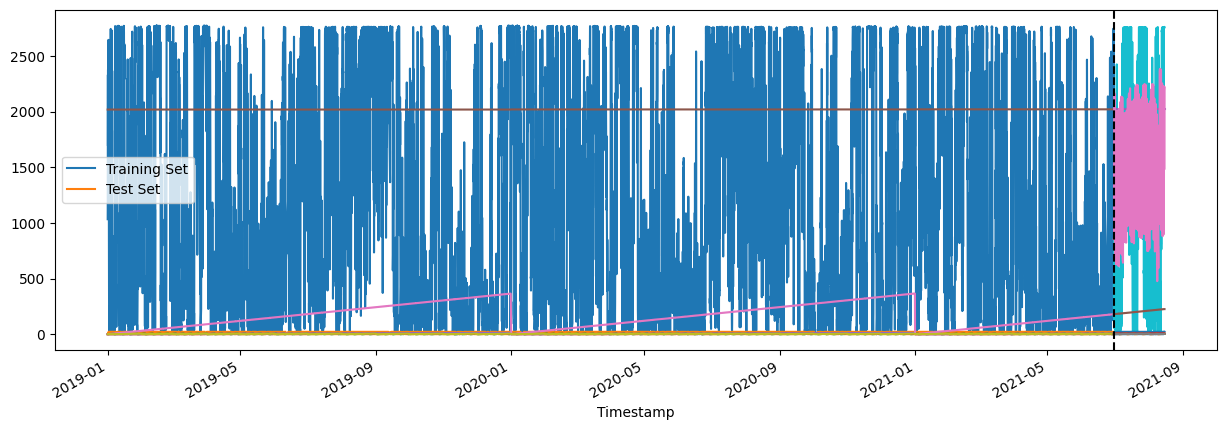

In [54]:
train = df_day_avg.loc[df_day_avg.index <= '06-30-2021']
test = df_day_avg.loc[df_day_avg.index > '06-30-2021']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('06-30-2021', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [55]:
train.columns

Index(['Power(kW)', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'prediction', 'week'],
      dtype='object')

In [56]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear','week']
target = 'Power(kW)'

In [57]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18608, 7)
(18608,)
(1005, 7)
(1005,)


In [59]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train),
                                      (X_test, y_test)],
                                      verbose = True)

[0]	validation_0-rmse:1661.27437	validation_1-rmse:1806.22845
[1]	validation_0-rmse:1649.27230	validation_1-rmse:1792.99995
[2]	validation_0-rmse:1637.42391	validation_1-rmse:1779.95263
[3]	validation_0-rmse:1625.72176	validation_1-rmse:1767.02126
[4]	validation_0-rmse:1614.16926	validation_1-rmse:1754.33119
[5]	validation_0-rmse:1602.76139	validation_1-rmse:1741.75505
[6]	validation_0-rmse:1591.50333	validation_1-rmse:1729.41551
[7]	validation_0-rmse:1580.38703	validation_1-rmse:1717.18779
[8]	validation_0-rmse:1569.41754	validation_1-rmse:1705.19204
[9]	validation_0-rmse:1558.58954	validation_1-rmse:1693.40611


[10]	validation_0-rmse:1547.89942	validation_1-rmse:1681.68779
[11]	validation_0-rmse:1537.38326	validation_1-rmse:1670.91697
[12]	validation_0-rmse:1526.97058	validation_1-rmse:1659.58536
[13]	validation_0-rmse:1516.72168	validation_1-rmse:1647.64846
[14]	validation_0-rmse:1506.60833	validation_1-rmse:1637.31507
[15]	validation_0-rmse:1496.59029	validation_1-rmse:1626.58104
[16]	validation_0-rmse:1486.73685	validation_1-rmse:1614.24306
[17]	validation_0-rmse:1477.02053	validation_1-rmse:1603.66688
[18]	validation_0-rmse:1467.42947	validation_1-rmse:1592.55801
[19]	validation_0-rmse:1457.93017	validation_1-rmse:1582.35214
[20]	validation_0-rmse:1448.53805	validation_1-rmse:1570.40059
[21]	validation_0-rmse:1439.31941	validation_1-rmse:1558.89862
[22]	validation_0-rmse:1430.18005	validation_1-rmse:1547.41540
[23]	validation_0-rmse:1421.17697	validation_1-rmse:1535.91114
[24]	validation_0-rmse:1412.31828	validation_1-rmse:1524.86280
[25]	validation_0-rmse:1403.53477	validation_1-rmse:151

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [60]:
pd.DataFrame(data=reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values(by=['importance'],ascending=False)

,importance
dayofyear,0.268837
year,0.159489
hour,0.145309
week,0.131328
dayofweek,0.105893
month,0.097072
quarter,0.092072


## Forecast on Test

In [68]:
test['prediction']=reg.predict(X_test)

In [69]:
test.head()

,Power(kW),hour,dayofweek,quarter,month,year,dayofyear,prediction,week
Timestamp,,,,,,,,,
2021-06-30 01:00:00,443.896942,1,2,2,6,2021,181,852.264526,5
2021-06-30 02:00:00,406.592222,2,2,2,6,2021,181,835.223328,5
2021-06-30 03:00:00,150.517501,3,2,2,6,2021,181,835.223328,5
2021-06-30 04:00:00,236.483332,4,2,2,6,2021,181,835.223328,5
2021-06-30 05:00:00,196.593334,5,2,2,6,2021,181,835.223328,5


In [70]:
df_day_avg = df_day_avg.merge(test[['prediction']], how='left', left_index=True, right_index=True)


In [71]:
df_day_avg.tail()

,Power(kW),hour,dayofweek,quarter,month,year,dayofyear,prediction_x,week,prediction_y,prediction
Timestamp,,,,,,,,,,,
2021-08-14 19:00:00,2758.577759,19,5,3,8,2021,226,2221.811035,3,2124.293701,2124.293701
2021-08-14 20:00:00,2757.170573,20,5,3,8,2021,226,2224.849854,3,2108.489014,2108.489014
2021-08-14 21:00:00,2757.608602,21,5,3,8,2021,226,2000.709961,3,1881.232056,1881.232056
2021-08-14 22:00:00,2758.276937,22,5,3,8,2021,226,1745.635864,3,1629.485352,1629.485352
2021-08-14 23:00:00,2758.955526,23,5,3,8,2021,226,1488.305420,3,1435.981445,1435.981445


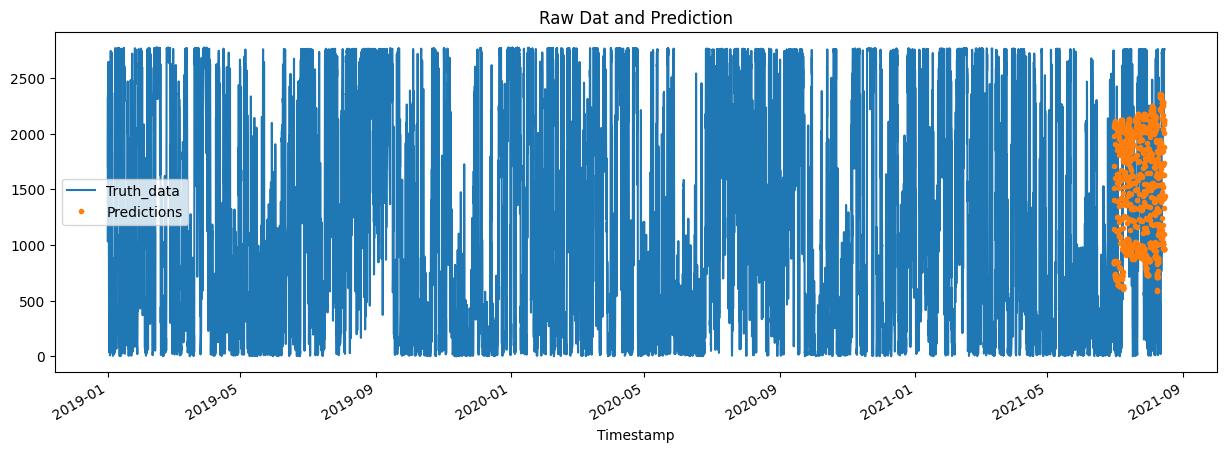

In [72]:
ax = df_day_avg[['Power(kW)']].plot(figsize=(15, 5))
df_day_avg['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth_data','Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

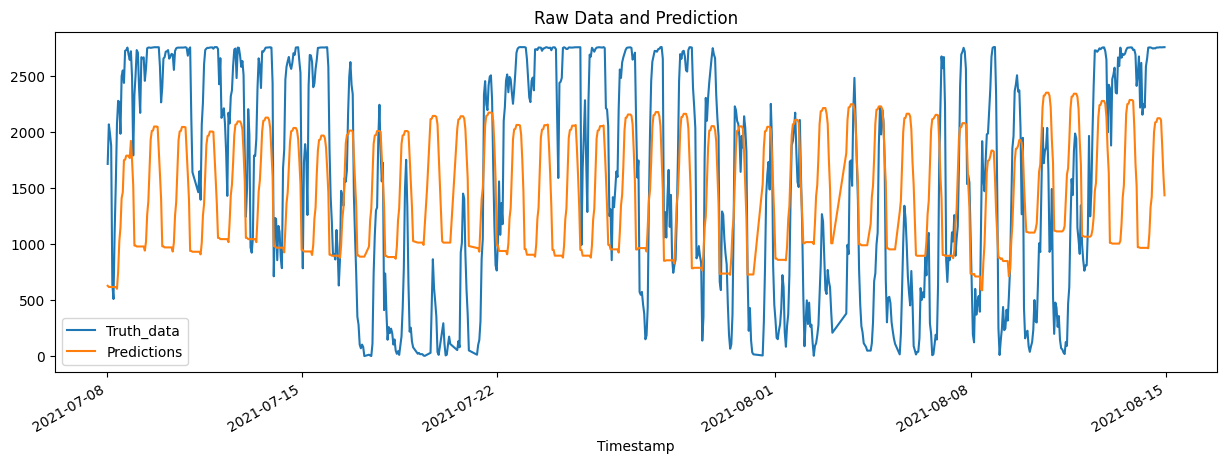

In [79]:
ax = df_day_avg.loc[(df_day_avg.index> '07-08-2021') & (df_day_avg.index < '10-08-2021')]['Power(kW)'].plot(figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW daily avergae')
df_day_avg.loc[(df_day_avg.index> '07-08-2021') & (df_day_avg.index < '10-08-2021')]['prediction'].plot(figsize = (15, 5), title = 'Wind Turbine ENergy Produced in KW daily avergae')
plt.legend(['Truth_data','Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()